# RNN Modeling of Weight Data

## Setup

In [1]:
from wlp_utils import ml_utils

import importlib
import datetime

%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from ggplot import *

Using TensorFlow backend.
/Users/jamieinfinity/.local/lib/python3.5/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/Users/jamieinfinity/.local/lib/python3.5/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp


In [172]:
importlib.reload(ml_utils)

<module 'wlp_utils.ml_utils' from '/Users/jamieinfinity/Projects/WorldLine/worldline-wgt/server/src/wlp_utils/ml_utils.py'>

## Data

In [2]:
this=ml_utils.get_model_data_df('2015-09-16', '2020-01-01')
this.tail(5)

,Weight,Steps,Calories
Date,,,
2017-09-04,171.4,13815.0,3066.0
2017-09-05,172.2,14598.0,2017.0
2017-09-06,168.8,19121.0,2954.0
2017-09-07,169.6,14247.0,1915.0
2017-09-08,168.1,22544.0,2236.0


In [3]:
x_train, y_train, dates = ml_utils.get_model_data_seq('2015-09-16', '2015-09-30', 10, shuffle=False)

In [4]:
WGT_SCALE_FACTOR = 50
NUM_FEATURES = 3
SEQUENCE_LENGTH = 30
TEST_DAYS = 90
HOLDOUT_DAYS = 30
NFOLDS = 5

[(features_train, target_train, dates_train), (features_test, target_test, dates_test), (features_holdout, target_holdout, dates_holdout)] = ml_utils.get_model_data_splits(
    sequence_length=SEQUENCE_LENGTH, 
    holdout_days=HOLDOUT_DAYS, 
    test_days=TEST_DAYS
)

In [5]:
len(features_train)

574

## Model Building

### Parameters

In [78]:
model_params = {
    'num_features':NUM_FEATURES,
    'sequence_length':SEQUENCE_LENGTH,
    'lstm_sizes':[256],
    'lstm_dropout_rates':[0.05]
}
# model_params = {
#     'num_features':NUM_FEATURES,
#     'sequence_length':SEQUENCE_LENGTH,
#     'lstm_sizes':[64, 32, 16],
#     'lstm_dropout_rates':[0.15, 0.1, 0.05]
# }
training_params = {
    'verboseness':0,
    'loss_function':'mean_absolute_error',
    'optimization_method':'adam',
    'batch_size':10,
    'epochs':10000,
    'early_stopping_patience':7,
    'min_delta':0.001
}

### Train CV models

In [79]:
kfold = KFold(n_splits=NFOLDS, shuffle=True, random_state=42)

models = []
val_losses = []
cv_indices = []
for train_index, val_index in kfold.split(features_train):
    cv_indices.append((train_index, val_index))
    X_train, X_val = features_train[train_index], features_train[val_index]
    y_train, y_val = target_train[train_index], target_train[val_index]
    X_test, y_test = X_val, y_val
#    X_test, y_test = features_test, target_test
    model = ml_utils.train_model(model_params, training_params, [(X_train, y_train), (X_test, y_test)])
    loss = model.evaluate(X_test, y_test, verbose=0)
    print(loss)
    val_losses.append(loss)
    models.append(model)
#     break

0.017575599156
0.0180789084619
0.0176811511669
0.0175378374108
0.0185011241324


In [80]:
np.array(val_losses).mean()*WGT_SCALE_FACTOR

0.89374620327903609

## Errors Over Sequence of Days

In [81]:
cv_index = 0
train_index = cv_indices[cv_index][0]
val_index = cv_indices[cv_index][1]
X_train, X_val = features_train[train_index], features_train[val_index]
y_train, y_val = target_train[train_index], target_train[val_index]
# X, y = X_train, y_train
X, y = X_val, y_val
# X, y = features_test, target_test
errors = np.array([0 for i in range(0,len(X[0]))])
model = models[cv_index]
for i in range(0, len(X)):
    x_in = np.array([X[i]])
    pred = model.predict(x_in)[0]
    true = y[i]
    errors = errors + np.abs(true-pred).reshape(len(X[0]))
errors = WGT_SCALE_FACTOR*errors/len(X)

In [82]:
np.mean(errors)/WGT_SCALE_FACTOR

0.01757559994017709

In [83]:
errors[-1]

0.95410940412091894

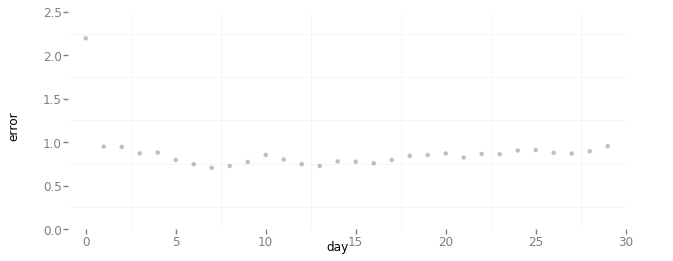

In [84]:
errors_df = pd.DataFrame({'day':range(0,len(X[0])), 'error':errors})

p = ggplot(aes(x='day', y='error'), data=errors_df) +\
geom_point(color='black', alpha=0.25)  +\
scale_x_continuous(limits=(-1, 30)) +\
scale_y_continuous(limits=(0, 2.5)) +\
theme_bw()

p.save('test.png', width=10, height=4)

## Errors Over Data Set

### Training set

In [85]:
weight_target = [ml_utils.weight_inverse_transform(x[0]) for x in target_train[:,-1]]
dates_target = [x + np.timedelta64(1, 'D') for x in dates_train[:,-1]]
weight_target_df = pd.DataFrame({'date': dates_target, 'weight': weight_target})

(dates_target_min, dates_target_max) = (dates_target[0]-np.timedelta64(5,'D'), dates_target[-1]+np.timedelta64(5,'D'))

weight_pred_folds = []
for fold in range(5):
    model = models[fold]
    weight_pred = [model.predict(np.array([x]))[0][-1][0] for x in features_train]
    weight_pred = [ml_utils.weight_inverse_transform(x) for x in weight_pred]
    weight_pred_folds.append(weight_pred)
    
weight_pred_folds = np.array(weight_pred_folds).transpose()
weight_pred_mean = weight_pred_folds.mean(axis=1)
weight_pred_std = weight_pred_folds.std(axis=1)
weight_pred_min = weight_pred_mean - weight_pred_std
weight_pred_max = weight_pred_mean + weight_pred_std
weight_pred_df = pd.DataFrame({'date':dates_target, 'weight':weight_pred_mean, 'wmin':weight_pred_min, 'wmax':weight_pred_max})

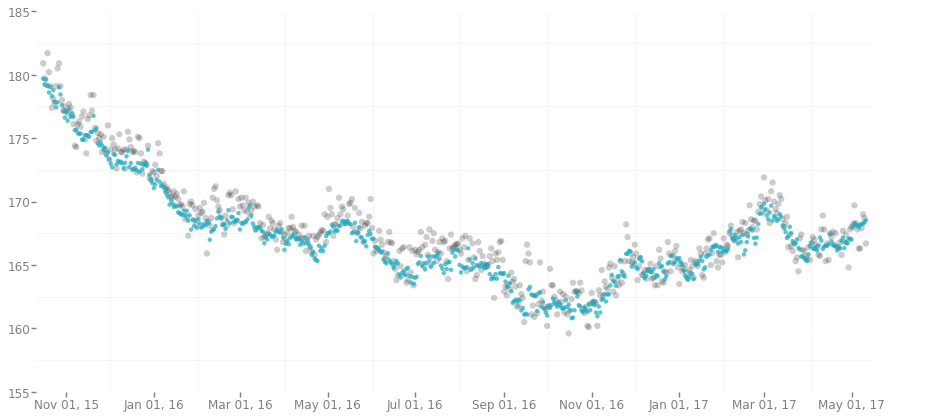

In [86]:
p = ggplot(aes(x='date', y='weight'), data=weight_target_df) +\
geom_point(color='black', alpha=0.2, size=40) +\
geom_point(data=weight_pred_df, color='#1DAABF', alpha=0.7, size=20) +\
scale_y_continuous(limits=(155, 185)) +\
scale_x_date(labels = date_format("%b %d, %y"), breaks = date_breaks('month'), limits=(dates_target_min, dates_target_max)) +\
xlab(element_text(size=12, text=' ')) +\
ylab(element_text(size=12, text=' ')) +\
theme_bw()

p.save('test.png', width=15, height=7)

#geom_ribbon(aes(x='date', ymin='wmin', ymax='wmax'), fill='#1DAABF', alpha=0.5, data=weight_pred_df) +\


### Test set

In [87]:
weight_target = [ml_utils.weight_inverse_transform(x[0]) for x in target_test[:,-1]]
dates_target = [x + np.timedelta64(1, 'D') for x in dates_test[:,-1]]
days_target = list(range(len(dates_target)))
weight_target_df = pd.DataFrame({'day':days_target, 'date': dates_target, 'weight': weight_target})

(dates_target_min, dates_target_max) = (dates_target[0]-np.timedelta64(5,'D'), dates_target[-1]+np.timedelta64(5,'D'))

weight_pred_folds = []
for fold in range(5):
    model = models[fold]
    weight_pred = [model.predict(np.array([x]))[0][-1][0] for x in features_test]
    weight_pred = [ml_utils.weight_inverse_transform(x) for x in weight_pred]
    weight_pred_folds.append(weight_pred)
    
weight_pred_folds = np.array(weight_pred_folds).transpose()
weight_pred_mean = weight_pred_folds.mean(axis=1)
weight_pred_std = weight_pred_folds.std(axis=1)
weight_pred_min = weight_pred_mean - weight_pred_std
weight_pred_max = weight_pred_mean + weight_pred_std
weight_pred_df = pd.DataFrame({'day':days_target, 'date':dates_target, 'weight':weight_pred_mean, 'wmin':weight_pred_min, 'wmax':weight_pred_max})

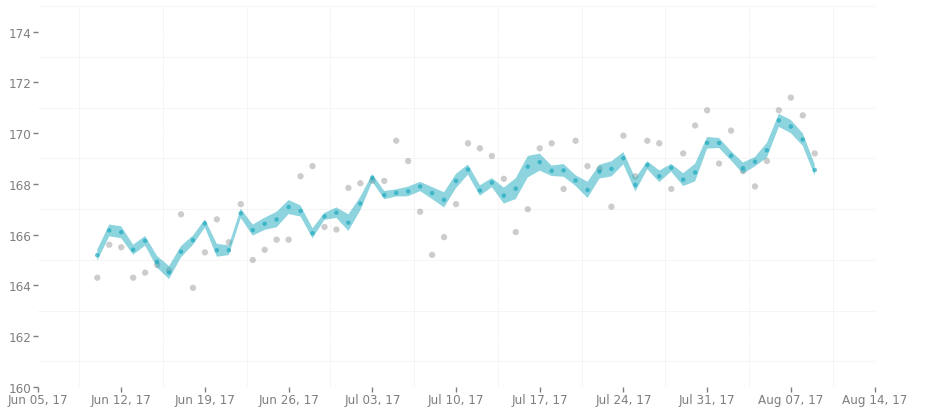

In [88]:
p = ggplot(aes(x='date', y='weight'), data=weight_target_df) +\
geom_point(color='black', alpha=0.2, size=40) +\
geom_point(data=weight_pred_df, color='#1DAABF', alpha=0.7, size=20) +\
geom_ribbon(aes(x='date', ymin='wmin', ymax='wmax'), fill='#1DAABF', alpha=0.5, data=weight_pred_df) +\
scale_y_continuous(limits=(160, 175)) +\
scale_x_date(labels = date_format("%b %d, %y"), breaks = date_breaks('month'), limits=(dates_target_min, dates_target_max)) +\
xlab(element_text(size=12, text=' ')) +\
ylab(element_text(size=12, text=' ')) +\
theme_bw()

p.save('test.png', width=15, height=7)

## Forecasted Predictions

### Training set

In [103]:
weight_target = [ml_utils.weight_inverse_transform(x[0]) for x in target_train[:,-1]]
dates_target = [x + np.timedelta64(1, 'D') for x in dates_train[:,-1]]
weight_target_df = pd.DataFrame({'date': dates_target, 'weight': weight_target})

(dates_target_min, dates_target_max) = (dates_target[0]-np.timedelta64(5,'D'), dates_target[-1]+np.timedelta64(5,'D'))

In [110]:
weight_pred_folds = []
for fold in range(5):
    model = models[fold]
    rolling_sequence = features_train[0]
    weight_pred = []
    for t in range(1, len(dates_target)):
        pred = model.predict(np.array([rolling_sequence]))[0][-1][0]
        weight_pred.append(pred)
        features_next = features_train[t][-1]
        features_next[0] = pred
        rolling_sequence = rolling_sequence[1:SEQUENCE_LENGTH]
        rolling_sequence = np.append(rolling_sequence, np.array([features_next]), axis=0)
    final_pred = model.predict(np.array([rolling_sequence]))[0][-1][0]
    weight_pred.append(final_pred)
    weight_pred = [ml_utils.weight_inverse_transform(x) for x in weight_pred]
    weight_pred_folds.append(weight_pred)

weight_pred_folds = np.array(weight_pred_folds).transpose()
weight_pred_mean = weight_pred_folds.mean(axis=1)
weight_pred_std = weight_pred_folds.std(axis=1)
weight_pred_min = weight_pred_mean - weight_pred_std
weight_pred_max = weight_pred_mean + weight_pred_std
weight_pred_df = pd.DataFrame({'date':dates_target, 'weight':weight_pred_mean, 'wmin':weight_pred_min, 'wmax':weight_pred_max})

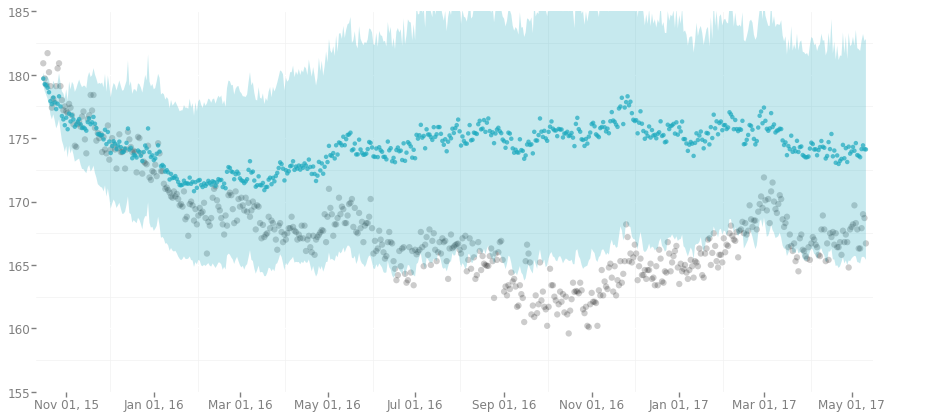

In [111]:
p = ggplot(aes(x='date', y='weight'), data=weight_target_df) +\
geom_point(color='black', alpha=0.2, size=40) +\
geom_point(data=weight_pred_df, color='#1DAABF', alpha=0.7, size=20) +\
geom_ribbon(aes(x='date', ymin='wmin', ymax='wmax'), fill='#1DAABF', alpha=0.25, data=weight_pred_df) +\
scale_y_continuous(limits=(155, 185)) +\
scale_x_date(labels = date_format("%b %d, %y"), breaks = date_breaks('month'), limits=(dates_target_min, dates_target_max)) +\
xlab(element_text(size=12, text=' ')) +\
ylab(element_text(size=12, text=' ')) +\
theme_bw()

p.save('test.png', width=15, height=7)

In [108]:
weight_pred_mean = []
weight_pred_std = []
rolling_sequence = features_train[0]
for t in range(1, len(dates_target)):
    weight_pred_folds = np.array([])
    for fold in range(5):
        model = models[fold]
        pred = model.predict(np.array([rolling_sequence]))[0][-1][0]
        weight_pred_folds = np.append(weight_pred_folds, pred)
    weight_mean = np.mean(weight_pred_folds)
    weight_std = np.std([ml_utils.weight_inverse_transform(x) for x in weight_pred_folds])
    weight_pred_mean.append(ml_utils.weight_inverse_transform(weight_mean))
    weight_pred_std.append(weight_std)
    features_next = features_train[t][-1]
    features_next[0] = weight_mean
    rolling_sequence = rolling_sequence[1:SEQUENCE_LENGTH]
    rolling_sequence = np.append(rolling_sequence, np.array([features_next]), axis=0)

weight_pred_folds = np.array([])    
for fold in range(5):
    model = models[fold]
    pred = model.predict(np.array([rolling_sequence]))[0][-1][0]
    weight_pred_folds = np.append(weight_pred_folds, pred)
weight_mean = np.mean(weight_pred_folds)
weight_std = np.std(weight_pred_folds)
weight_pred_mean.append(weight_mean)
weight_pred_std.append(weight_std)
weight_pred_mean = np.array(weight_pred_mean)
weight_pred_std = np.array(weight_pred_std)
weight_pred_min = weight_pred_mean - weight_pred_std
weight_pred_max = weight_pred_mean + weight_pred_std
weight_pred_df = pd.DataFrame({'date':dates_target, 'weight':weight_pred_mean, 'wmin':weight_pred_min, 'wmax':weight_pred_max})

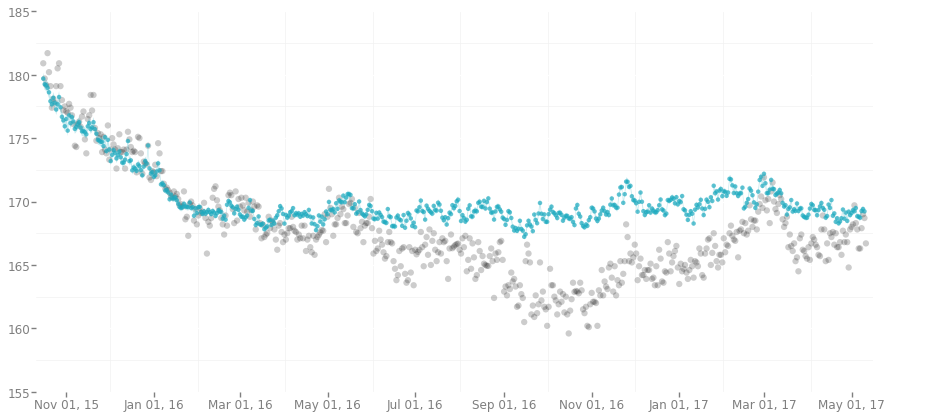

In [109]:
p = ggplot(aes(x='date', y='weight'), data=weight_target_df) +\
geom_point(color='black', alpha=0.2, size=40) +\
geom_point(data=weight_pred_df, color='#1DAABF', alpha=0.7, size=20) +\
geom_ribbon(aes(x='date', ymin='wmin', ymax='wmax'), fill='#1DAABF', alpha=0.25, data=weight_pred_df) +\
scale_y_continuous(limits=(155, 185)) +\
scale_x_date(labels = date_format("%b %d, %y"), breaks = date_breaks('month'), limits=(dates_target_min, dates_target_max)) +\
xlab(element_text(size=12, text=' ')) +\
ylab(element_text(size=12, text=' ')) +\
theme_bw()

p.save('test.png', width=15, height=7)

### Test set

In [112]:
weight_target = [ml_utils.weight_inverse_transform(x[0]) for x in target_test[:,-1]]
dates_target = [x + np.timedelta64(1, 'D') for x in dates_test[:,-1]]
days_target = list(range(len(dates_target)))
weight_target_df = pd.DataFrame({'day':days_target, 'date': dates_target, 'weight': weight_target})

(dates_target_min, dates_target_max) = (dates_target[0]-np.timedelta64(5,'D'), dates_target[-1]+np.timedelta64(5,'D'))

In [93]:
weight_pred_folds = []
for fold in range(5):
    model = models[fold]
    rolling_sequence = features_test[0]
    weight_pred = []
    for t in range(1, len(dates_target)):
        pred = model.predict(np.array([rolling_sequence]))[0][-1][0]
        weight_pred.append(pred)
        features_next = features_test[t][-1]
        features_next[0] = pred
        rolling_sequence = rolling_sequence[1:SEQUENCE_LENGTH]
        rolling_sequence = np.append(rolling_sequence, np.array([features_next]), axis=0)
    final_pred = model.predict(np.array([rolling_sequence]))[0][-1][0]
    weight_pred.append(final_pred)
    weight_pred = [ml_utils.weight_inverse_transform(x) for x in weight_pred]
    weight_pred_folds.append(weight_pred)

weight_pred_folds = np.array(weight_pred_folds).transpose()
weight_pred_mean = weight_pred_folds.mean(axis=1)
weight_pred_std = weight_pred_folds.std(axis=1)
weight_pred_min = weight_pred_mean - weight_pred_std
weight_pred_max = weight_pred_mean + weight_pred_std
weight_pred_df = pd.DataFrame({'day':days_target, 'date':dates_target, 'weight':weight_pred_mean, 'wmin':weight_pred_min, 'wmax':weight_pred_max})

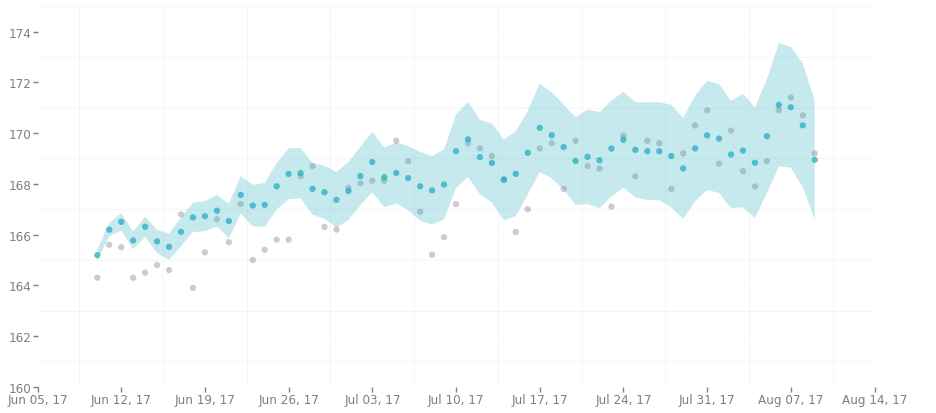

In [94]:
p = ggplot(aes(x='date', y='weight'), data=weight_target_df) +\
geom_point(color='black', alpha=0.2, size=40) +\
geom_point(data=weight_pred_df, color='#1DAABF', alpha=0.7, size=40) +\
geom_ribbon(aes(x='date', ymin='wmin', ymax='wmax'), fill='#1DAABF', alpha=0.25, data=weight_pred_df) +\
scale_y_continuous(limits=(160, 175)) +\
scale_x_date(labels = date_format("%b %d, %y"), breaks = date_breaks('month'), limits=(dates_target_min, dates_target_max)) +\
xlab(element_text(size=12, text=' ')) +\
ylab(element_text(size=12, text=' ')) +\
theme_bw()

p.save('test.png', width=15, height=7)

In [113]:
weight_pred_mean = []
weight_pred_std = []
rolling_sequence = features_test[0]
for t in range(1, len(dates_target)):
    weight_pred_folds = np.array([])
    for fold in range(5):
        model = models[fold]
        pred = model.predict(np.array([rolling_sequence]))[0][-1][0]
        weight_pred_folds = np.append(weight_pred_folds, pred)
    weight_mean = np.mean(weight_pred_folds)
    weight_std = np.std([ml_utils.weight_inverse_transform(x) for x in weight_pred_folds])
    weight_pred_mean.append(ml_utils.weight_inverse_transform(weight_mean))
    weight_pred_std.append(weight_std)
    features_next = features_test[t][-1]
    features_next[0] = weight_mean
    rolling_sequence = rolling_sequence[1:SEQUENCE_LENGTH]
    rolling_sequence = np.append(rolling_sequence, np.array([features_next]), axis=0)

weight_pred_folds = np.array([])    
for fold in range(5):
    model = models[fold]
    pred = model.predict(np.array([rolling_sequence]))[0][-1][0]
    weight_pred_folds = np.append(weight_pred_folds, pred)
weight_mean = np.mean(weight_pred_folds)
weight_std = np.std(weight_pred_folds)
weight_pred_mean.append(weight_mean)
weight_pred_std.append(weight_std)
weight_pred_mean = np.array(weight_pred_mean)
weight_pred_std = np.array(weight_pred_std)
weight_pred_min = weight_pred_mean - weight_pred_std
weight_pred_max = weight_pred_mean + weight_pred_std
weight_pred_df = pd.DataFrame({'date':dates_target, 'weight':weight_pred_mean, 'wmin':weight_pred_min, 'wmax':weight_pred_max})

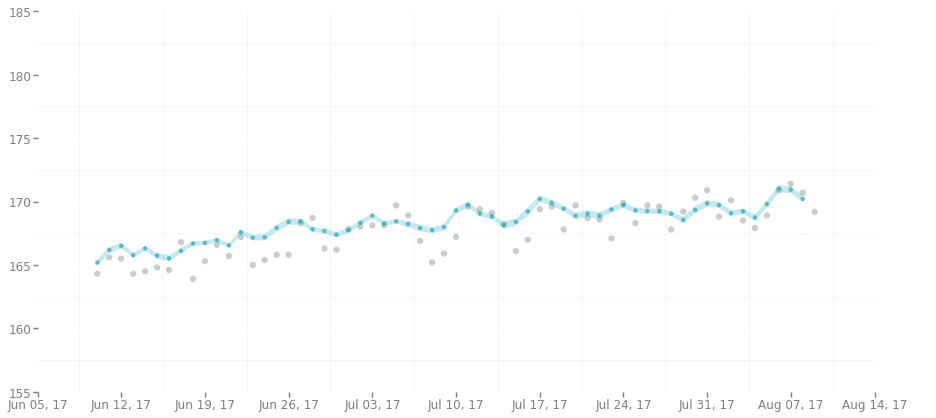

In [114]:
p = ggplot(aes(x='date', y='weight'), data=weight_target_df) +\
geom_point(color='black', alpha=0.2, size=40) +\
geom_point(data=weight_pred_df, color='#1DAABF', alpha=0.7, size=20) +\
geom_ribbon(aes(x='date', ymin='wmin', ymax='wmax'), fill='#1DAABF', alpha=0.25, data=weight_pred_df) +\
scale_y_continuous(limits=(155, 185)) +\
scale_x_date(labels = date_format("%b %d, %y"), breaks = date_breaks('month'), limits=(dates_target_min, dates_target_max)) +\
xlab(element_text(size=12, text=' ')) +\
ylab(element_text(size=12, text=' ')) +\
theme_bw()

p.save('test.png', width=15, height=7)